# Analyze and compare the profits of two telecom plans

The telecom company Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.

This project conducts an analysis of the two plans to see which plan is more profitable. The datasets include info of: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. The goal of the project is to analyze clients' behavior and determine which prepaid plan is more profitable.

# Step 1. Open the data files and study the general information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import functools
import scipy as sp
from datetime import datetime
from datetime import timedelta
from scipy import stats
from scipy.stats import mannwhitneyu

#### Load datasets

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_calls.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_messages.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_internet.csv')
plans = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_plans.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_users1.csv')

In [3]:
calls.info()
len(calls['user_id'].unique()) #481
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
messages.info()
len(messages['user_id'].unique()) #402
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [5]:
internet.info()
len(internet['user_id'].unique()) #489
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [6]:
plans.info()
plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
users.info()
users.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN
499,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN


## Conclusion of Step 1
- There are 5 separate dataframes which will need to be merged in the next step. The common variable that will be used to merge is user_id (int) and plan_name (object)
- It's good that there are no missing values in almost all columns of the 5 datasets, except for the churn_date in the users data (by looking at the number of non-null observations in each dataframe). However, when merging them, there will be missing values 

# Step 2. Prepare the data

## 1. Convert the data to the necessary types
After doing a preliminary check of the data sets, the first thing need to convert is the date_time format. Other necessary format change will be conducted along the project.

#### users data: change "reg_date", "churn_date" to date_time format

In [8]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d %H:%M:%S')

#### Fill in missing values by the last day of the year for "churn_date" to calculate the monthly profit in the next tasks

In [9]:
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

#### Change to date_time format

In [10]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d %H:%M:%S')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    500 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


#### 'calls' data: 
- Change "call_date" to date_time format 
- Call duration: round up to 1 minute (according to the instruction)

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S')
calls['duration'] = calls['duration'].apply(np.ceil)
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0


#### 'messages' data: Change "message_date" to date_time format

In [12]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


#### 'internet' data: 
- Change "session_date" to date_time format 
- mb_used: round up (according to the instruction)

In [13]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,90.0
1,1000_204,1000,2018-12-31,0.0
2,1000_379,1000,2018-12-28,661.0
3,1000_413,1000,2018-12-26,271.0
4,1000_442,1000,2018-12-27,881.0


## 2. Find and eliminate errors in the data

### Strategy

### - Drop user identifier like first name and last name to avoid data leakage

### - Check and drop duplicated rows (rows that have same values for all columns)

### - 'users': The following item(s) need to be fixed/added:
- Clean the "city" column and extract the state, specifically code those observations that have "NY" or "NJ" as 1, the rest as 0. MSA - the term mentioned in the "city" column, Metropolitan Statistical Area, is one or more adjacent counties, or county equivalents, that have at least one urban core area of at least 50,000 population, plus adjacent territory that has a high degree of social and economic integration with the core as measured by the commuting tie. Metropolitan statistical areas (MSA) serve to group counties and cities into specific geographic areas for population censuses and compilations of related statistical data. This explains why there are multiple cities/states in the "city" column. 
- Compare "reg_date" and "churn_date" to see if there is any error (ex. churn_date before reg_date)

### - 'calls': The following item(s) need to be fixed/added:
- Clean the "duration" column: identify the suspectedly quick/long call duration and determine how to deal with them

### - 'messages': nothing need to be fixed/added

### - 'internet': The following item(s) need to be fixed/added:
- Clean the "mb_used" column: identify the suspectedly low/high data usage and determine how to deal with them
- Add another column of "gb_used" based on the "mb_used"

### - 'plans': nothing need to be fixed/added

### 2.1. Drop users' first and last name to avoid data leakage

In [14]:
users = users.drop(['first_name', 'last_name'], axis=1)
users.head()

,user_id,age,city,reg_date,plan,churn_date
0,1000,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31
1,1001,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31
2,1002,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2018-12-31
3,1003,52,"Tulsa, OK MSA",2018-01-28,surf,2018-12-31
4,1004,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2018-12-31


### 2.2. Check and drop duplicated rows

In [15]:
users[users.duplicated(keep = False)] #no duplicates

,user_id,age,city,reg_date,plan,churn_date


In [16]:
calls[calls.duplicated(keep = False)] #no duplicates

,id,user_id,call_date,duration


In [17]:
messages[messages.duplicated(keep = False)] #no duplicates

,id,user_id,message_date


In [18]:
internet[internet.duplicated(keep = False)] #no duplicates

,id,user_id,session_date,mb_used


### 2.3. 'users' data: create column "NY-NJ": True if "city" contains "NY", "NJ" or both 

In [19]:
users.head()
users['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [20]:
users['NY_NJ'] = users['city'].str.contains("NY|NJ")
users['NY_NJ'].sum() #103 users in NY or NJ or NY-NJ areas

103

#### Check if there is any error that churn_date is before reg_date

In [21]:
users.query('churn_date < reg_date') #No errors found

,user_id,age,city,reg_date,plan,churn_date,NY_NJ


### 2.4. 'calls' data: clean the "duration" column

In [22]:
calls['duration'].describe()

count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

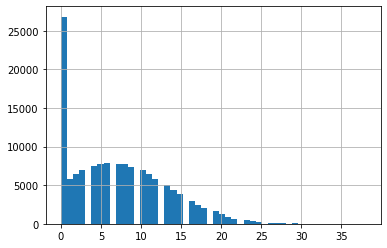

In [23]:
calls['duration'].hist(bins=50)

In [24]:
(calls['duration'] == 0).mean() 

0.1948233927469416

There are 26834 calls that last for 0 mins, accounting for nearly 20% of the data

In [25]:
(calls['duration'] >24).sum() 

701

701 observations, accounting for 0.5% of data, not much

### Too short call
- Because the number of observations that have calls last for 0 minute represents 20% of the dataset (too many), I decide NOT to process (drop or repalce with mean) these values. Processing these values might lead to bias in the relationship between call duration and other variables. Also, it makes sense that 0 minute-calls represent missed calls, it's common to see missed calls daily. 

### Too long call
- Beside the peak around zero, the graph has its (rather flat) peak around 6 minutes, most of duration range from 1.2 to 10.7 minutes. Calls that last more than 24 minutes are already rare, here the histogram merges with zero. But not to drop these long calls (will drop if need to build machine learning model)

### 2.5. 'internet' data: clean the "mb_used" column

In [26]:
internet['mb_used'].describe()

count    104825.000000
mean        367.142876
std         277.256974
min           0.000000
25%         137.000000
50%         344.000000
75%         555.000000
max        1694.000000
Name: mb_used, dtype: float64

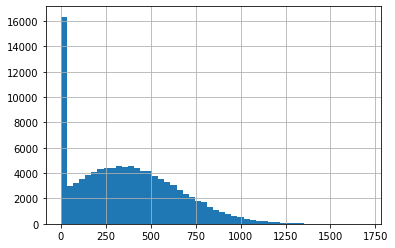

In [27]:
internet['mb_used'].hist(bins=50)

In [28]:
(internet['mb_used'] == 0).sum() 

13747

There are 13747 users whose data usage is 0, accounting for around 13% of the data

In [29]:
(internet['mb_used'] >1200).sum() 

364

364 observations, accounting for 0.3% of data, this is a tiny number

### Too low data usage
- Because the number of users whose data usage is 0 megabite represents around 13% of the dataset (too many), I decide NOT to process (drop or replace with mean) these values. Processing these values might lead to bias in the relationship between call duration and other variables. Also, it makes sense that 0 megabite-data-use means that users do not use internet via phone.

### Too high data usage
- Beside the peak at zero, the graph has its second peak around 350 megabites, most of data usage range from 136 to 554 megabites. Users who use more than 1200 megabites are already rare, here the histogram merges with zero. But not to drop any outliers here.

## 3. Aggregate monthly info for each users (number of calls/texts, volume of data) and calculate monthly profit from each user (flat fee plus exceeding fee)


### 3.1 Prepare the datasets and calculate # of calls, call duration, number of texts, and volume of data

#### Extract month from the calls data

In [30]:
calls['call_month'] = calls['call_date'].dt.month
calls.head()

,id,user_id,call_date,duration,call_month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


#### Extract month from the messages data

In [31]:
messages['message_month'] = messages['message_date'].dt.month
messages.head()

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


#### Extract month from the internet data

In [32]:
internet['internet_month'] = internet['session_date'].dt.month
internet.head()

,id,user_id,session_date,mb_used,internet_month
0,1000_13,1000,2018-12-29,90.0,12
1,1000_204,1000,2018-12-31,0.0,12
2,1000_379,1000,2018-12-28,661.0,12
3,1000_413,1000,2018-12-26,271.0,12
4,1000_442,1000,2018-12-27,881.0,12


### Aggregate monthly calls for each user

In [33]:
calls.head()

,id,user_id,call_date,duration,call_month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


In [34]:
monthly_calls = calls.groupby(['user_id', 'call_month']).agg({'duration': ['count', 'sum']}).reset_index()
monthly_calls.info()
monthly_calls.columns = ['user_id', 'month','call_sum', 'call_duration_minute']
monthly_calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
(user_id, )          2258 non-null int64
(call_month, )       2258 non-null int64
(duration, count)    2258 non-null int64
(duration, sum)      2258 non-null float64
dtypes: float64(1), int64(3)
memory usage: 70.7 KB


,user_id,month,call_sum,call_duration_minute
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0
5,1001,12,56,412.0
6,1002,10,11,59.0
7,1002,11,55,386.0
8,1002,12,47,384.0
9,1003,12,149,1104.0


### Aggregate monthly text messages for each user

In [35]:
messages.head()

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [36]:
monthly_msg = messages.groupby(['user_id', 'message_month']).agg({'id': ['count']}).reset_index()
monthly_msg.info()
monthly_msg.columns = ['user_id', 'month','message_sum']
monthly_msg.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
(user_id, )          1806 non-null int64
(message_month, )    1806 non-null int64
(id, count)          1806 non-null int64
dtypes: int64(3)
memory usage: 42.5 KB


,user_id,month,message_sum
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15
7,1002,11,32
8,1002,12,41
9,1003,12,50


In [37]:
monthly_msg['month'].unique()

array([12,  8,  9, 10, 11,  5,  6,  7,  2,  3,  4,  1])

### Aggregate monthly internet data volume for each user

In [38]:
internet.head()

,id,user_id,session_date,mb_used,internet_month
0,1000_13,1000,2018-12-29,90.0,12
1,1000_204,1000,2018-12-31,0.0,12
2,1000_379,1000,2018-12-28,661.0,12
3,1000_413,1000,2018-12-26,271.0,12
4,1000_442,1000,2018-12-27,881.0,12


In [39]:
monthly_data = internet.groupby(['user_id', 'internet_month']).agg({'mb_used': ['sum']}).reset_index()
monthly_data.info()
monthly_data.columns = ['user_id', 'month','data_volume']
monthly_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
(user_id, )           2277 non-null int64
(internet_month, )    2277 non-null int64
(mb_used, sum)        2277 non-null float64
dtypes: float64(1), int64(2)
memory usage: 53.5 KB


,user_id,month,data_volume
0,1000,12,1903.0
1,1001,8,6929.0
2,1001,9,13333.0
3,1001,10,22356.0
4,1001,11,18524.0
5,1001,12,19398.0
6,1002,10,6559.0
7,1002,11,19364.0
8,1002,12,14416.0
9,1003,12,27069.0


### Merge the above data sets (calls, messages, internet) with 'users' data to get plan name (surf - ultimate)

Change "month" to integer

In [40]:
monthly_calls["month"] = monthly_calls["month"].astype(int)
monthly_msg["month"] = monthly_msg["month"].astype(int)
monthly_data["month"] = monthly_data["month"].astype(int)

Merge users, calls, messages, and data into one dataframe called "monthly_plan"

In [41]:
monthly_plan = monthly_calls.merge(monthly_msg, on=['user_id','month'], how='outer')\
    .merge(monthly_data, on=['user_id','month'], how='outer')\
    .merge(users, on='user_id', how='left')
   
   
monthly_plan.info()
len(monthly_plan['user_id'].unique()) #490
monthly_plan.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 12 columns):
user_id                 2293 non-null int64
month                   2293 non-null int64
call_sum                2258 non-null float64
call_duration_minute    2258 non-null float64
message_sum             1806 non-null float64
data_volume             2277 non-null float64
age                     2293 non-null int64
city                    2293 non-null object
reg_date                2293 non-null datetime64[ns]
plan                    2293 non-null object
churn_date              2293 non-null datetime64[ns]
NY_NJ                   2293 non-null bool
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 217.2+ KB


,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,churn_date,NY_NJ
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,False
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False


#### Preprocess the monthly_plan data:
- Check missing data
- Identify and correct errors in any

In [42]:
monthly_plan.isnull().mean().sort_values()

user_id                 0.000000
month                   0.000000
age                     0.000000
city                    0.000000
reg_date                0.000000
plan                    0.000000
churn_date              0.000000
NY_NJ                   0.000000
data_volume             0.006978
call_sum                0.015264
call_duration_minute    0.015264
message_sum             0.212386
dtype: float64

The missing data in 'data_volume', 'call_sum', 'call_duration_minute' and 'message_sum' are natural because there are people who didn't use these services at all. Therefore no need to do anything with these missing values

#### Investigate if there are any users still use service after churn_date --> drop

In [43]:
#Prepare data
monthly_plan['churn_month'] = monthly_plan['churn_date'].dt.month
monthly_plan["churn_month"] = monthly_plan["churn_month"].astype('Int64')

In [44]:
#Look at users still use service after churn_date 
monthly_plan.dropna(subset=['churn_month', 'month'], how='any').query('churn_month < month', engine='python')

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,churn_date,NY_NJ,churn_month
54,1012,12,16.0,78.0,NaN,11889.0,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,False,11
80,1022,10,83.0,574.0,NaN,18987.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,True,9
81,1022,11,72.0,498.0,NaN,22236.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,True,9
82,1022,12,82.0,585.0,NaN,18314.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,True,9
212,1050,11,57.0,413.0,NaN,14245.0,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,False,10
213,1050,12,52.0,299.0,NaN,17066.0,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,False,10
311,1067,12,53.0,344.0,20.0,15968.0,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24,False,11
403,1084,12,103.0,720.0,81.0,27895.0,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11,False,11
497,1106,12,67.0,569.0,NaN,22177.0,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-10,surf,2018-11-14,True,11
809,1172,12,90.0,711.0,117.0,23685.0,72,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-30,surf,2018-11-29,False,11


Save the user_id in a list

In [45]:
user_outservice = monthly_plan.dropna(subset=['churn_month', 'month'], how='any').query(
    'churn_month < month', engine='python')['user_id'].unique()

user_outservice

array([1012, 1022, 1050, 1067, 1084, 1106, 1172, 1191, 1220, 1246, 1281,
       1315, 1358, 1363, 1414, 1416, 1441, 1466, 1467, 1491])

Drop these users

In [46]:
monthly_plan_clean = monthly_plan.query('user_id not in @user_outservice')
len(monthly_plan_clean['user_id'].unique())  #should be 470 (490-20)
monthly_plan_clean.head()

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,churn_date,NY_NJ,churn_month
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,False,12
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12


Now the clean dataframe ('monthly_plan_clean') that is merged from sub-datasets has info of number of calls (call_sum), call duration in minute ('call_duration_minute'), number of text messages ('message_sum'), volume of data in megabytes ('data_volume') and other necessary info.

### 3.2 Calculate the monthly profit from each user
Subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan

### 3.2.1 Prepare the data

In [47]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Merge monthly_plan_clean with the plans data to get the plan name

In [48]:
#Rename columns to merge with the monthly_plan_clean
plans = plans.rename(columns={"plan_name": "plan"}) 

#Merge
monthly_plan_clean = monthly_plan_clean.merge(plans, on='plan', how='left')

len(monthly_plan_clean['user_id'].unique()) #still 470

monthly_plan_clean.head()

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,churn_date,NY_NJ,churn_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,False,12,1000,30720,3000,70,7,0.01,0.01
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12,50,15360,500,20,10,0.03,0.03
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12,50,15360,500,20,10,0.03,0.03
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12,50,15360,500,20,10,0.03,0.03
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,False,12,50,15360,500,20,10,0.03,0.03


### 3.2.2 Calculate the monthly profit from each user

Add columns calculating the volume/number of exceeding free limit of each plan for call, texts and data

In [49]:
monthly_plan_clean = monthly_plan_clean.assign(
    minute_exceed = lambda x: (monthly_plan_clean['minutes_included'] - monthly_plan_clean['call_duration_minute']).round(decimals=2),         
    message_exceed = lambda x: monthly_plan_clean['messages_included'] - monthly_plan_clean['message_sum'],
    data_exceed = lambda x: ((monthly_plan_clean['mb_per_month_included'] - monthly_plan_clean['data_volume'])/1024).round(decimals=2)
)
monthly_plan_clean.head()

#Positive means the user did not exceed the free limit
#Negative value means the user exceeded the free limit


,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,2876.0,989.0,28.14
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,318.0,20.0,8.23
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,185.0,6.0,1.98
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,107.0,-3.0,-6.83
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,74.0,14.0,-3.09


- Correct the exceeding number, turn positive numbers into 0 --> user did not exceed the free limit
- Leave negative values as they are because these are the exceeding volumes

In [50]:
monthly_plan_clean = monthly_plan_clean.assign(
    minute_exceed = lambda x: monthly_plan_clean['minute_exceed'].where(monthly_plan_clean['minute_exceed'] <0, 0),         
    message_exceed = lambda x: monthly_plan_clean['message_exceed'].where(monthly_plan_clean['minute_exceed'] <0, 0),
    data_exceed = lambda x: monthly_plan_clean['data_exceed'].where(monthly_plan_clean['data_exceed'] <0, 0)
)

monthly_plan_clean.head()

#Zero means the user did not exceed the free limit
#Negative value means the user exceeded the free limit

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.00
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,0.0,0.0,0.00
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,0.0,0.0,0.00
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,0.0,0.0,-6.83
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,50,15360,500,20,10,0.03,0.03,0.0,0.0,-3.09


Multiply the exceeding unit with the corresponding price

In [51]:
monthly_plan_clean = monthly_plan_clean.assign(
    minute_exceed_usd = lambda x: (monthly_plan_clean['minute_exceed'] * monthly_plan_clean['usd_per_minute']).abs().round(decimals=2),         
    message_exceed_usd = lambda x: (monthly_plan_clean['message_exceed'] * monthly_plan_clean['usd_per_message']).abs().round(decimals=2),
    data_exceed_usd = lambda x: (monthly_plan_clean['data_exceed'] * monthly_plan_clean['usd_per_gb']).abs().round(decimals=2)
)
monthly_plan_clean.head(10)

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed,minute_exceed_usd,message_exceed_usd,data_exceed_usd
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,70,7,0.01,0.01,0.0,0.0,0.00,0.00,0.0,0.0
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,20,10,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,20,10,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,20,10,0.03,0.03,0.0,0.0,-6.83,0.00,0.0,68.3
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,20,10,0.03,0.03,0.0,0.0,-3.09,0.00,0.0,30.9
5,1001,12,56.0,412.0,44.0,19398.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,20,10,0.03,0.03,0.0,0.0,-3.94,0.00,0.0,39.4
6,1002,10,11.0,59.0,15.0,6559.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,20,10,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0
7,1002,11,55.0,386.0,32.0,19364.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,20,10,0.03,0.03,0.0,0.0,-3.91,0.00,0.0,39.1
8,1002,12,47.0,384.0,41.0,14416.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,20,10,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0
9,1003,12,149.0,1104.0,50.0,27069.0,52,"Tulsa, OK MSA",2018-01-28,surf,...,20,10,0.03,0.03,-604.0,0.0,-11.43,18.12,0.0,114.3


#### Calculate the monthly surcharge for each user by adding the exceeding fee of minute, number of messages and data volume (not including flat fee - will add later)

In [52]:
col_list = list(monthly_plan_clean[['minute_exceed_usd', 'message_exceed_usd', 'data_exceed_usd']])
                
monthly_plan_clean['monthly_surcharge'] = monthly_plan_clean[col_list].sum(axis=1)

monthly_plan_clean.head()

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,usd_per_gb,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed,minute_exceed_usd,message_exceed_usd,data_exceed_usd,monthly_surcharge
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,7,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,10,0.03,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,10,0.03,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,10,0.03,0.03,0.0,0.0,-6.83,0.0,0.0,68.3,68.3
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,10,0.03,0.03,0.0,0.0,-3.09,0.0,0.0,30.9,30.9


### Prepare the data: Calculate the monthly profit from each user (flat fee + exceeding fee), excluding the months that they did not use a service (call, text, internet)

Calculate the the monthly profit by adding monthly flat fee and monthly_surcharge

In [53]:
monthly_plan_clean['monthly_profit'] = monthly_plan_clean['usd_monthly_pay'] + monthly_plan_clean['monthly_surcharge']

    
monthly_plan_clean.head(20)

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed,minute_exceed_usd,message_exceed_usd,data_exceed_usd,monthly_surcharge,monthly_profit
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,0.01,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.00,70.00
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0,0.00,20.00
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0,0.00,20.00
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,-6.83,0.00,0.0,68.3,68.30,88.30
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,-3.09,0.00,0.0,30.9,30.90,50.90
5,1001,12,56.0,412.0,44.0,19398.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,-3.94,0.00,0.0,39.4,39.40,59.40
6,1002,10,11.0,59.0,15.0,6559.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0,0.00,20.00
7,1002,11,55.0,386.0,32.0,19364.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,0.03,0.03,0.0,0.0,-3.91,0.00,0.0,39.1,39.10,59.10
8,1002,12,47.0,384.0,41.0,14416.0,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,...,0.03,0.03,0.0,0.0,0.00,0.00,0.0,0.0,0.00,20.00
9,1003,12,149.0,1104.0,50.0,27069.0,52,"Tulsa, OK MSA",2018-01-28,surf,...,0.03,0.03,-604.0,0.0,-11.43,18.12,0.0,114.3,132.42,152.42


### Conclusion for Step 2
The above table (data) shows: For each user:
- The number of calls made and minutes used per month (under 'call_count' and 'call_duration_minute' respectively). 1, 2, 3.., 12: is the number of month.
- The number of text messages sent per month (under 'message_sum')
- The volume of data per month (under 'data_volume')
- Monthly profit from each customer (under 'monthly_profit')

# Step 3. Analyze the data
Find the minutes, texts, and volume of data the users of each plan require per month. Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions.

### 3.1. Calculate the mean, dispersion and standard deviation

In [54]:
monthly_plan_stat = monthly_plan_clean.groupby(['plan', 'month'])\
    .agg({'call_duration_minute':['mean', 'var', 'std'],
         'message_sum':['mean', 'var', 'std'],
         'data_volume':['mean', 'var', 'std']}).reset_index()

monthly_plan_stat

plan month call_duration_minute                           message_sum  \
                                   mean           var         std        mean   
0       surf     1           203.000000  15842.000000  125.865007   21.000000   
1       surf     2           297.000000  52226.500000  228.531179   21.600000   
2       surf     3           330.000000  35809.363636  189.233622   21.937500   
3       surf     4           369.234043  48779.574468  220.860984   25.606061   
4       surf     5           414.246377  57636.864876  240.076790   33.480769   
5       surf     6           436.322222  46309.411860  215.196217   33.927536   
6       surf     7           457.327434  60843.097187  246.663936   36.174419   
7       surf     8           417.113333  52358.262237  228.819279   37.720339   
8       surf     9           420.198895  45371.460221  213.005775   39.020979   
9       surf    10           437.622727  51168.190349  226.203869   42.234637   
10      surf    11           431.536122  49084.127507  221.549379   40.409302   
11      surf    12           486.868687  60530.283374  246.029030   48.221311   
12  ultimate     1           193.500000  16572.333333  128.733575   20.666667   
13  ultimate     2           440.200000  61121.200000  247.227021   25.000000   
14  ultimate     3           288.900000  60740.544444  246.455969   37.000000   
15  ultimate     4           321.277778  32495.624183  180.265427   29.857143   
16  ultimate     5           397.760000  48446.106667  220.104763   46.277778   
17  ultimate     6           381.634146  41224.787805  203.038882   36.914286   
18  ultimate     7           417.981818  74152.314478  272.309226   41.909091   
19  ultimate     8           418.597015  55663.244233  235.930592   49.092593   
20  ultimate     9           441.382716  60164.039198  245.283589   46.970149   
21  ultimate    10           456.465347  54491.051287  233.433184   47.337209   
22  ultimate    11           452.016529  61524.533058  248.041394   48.272727   
23  ultimate    12           462.972222  60004.264957  244.957680   54.524590   

                             data_volume                              
            var        std          mean           var           std  
0           NaN        NaN   4881.000000  1.827706e+07   4275.167599  
1    512.800000  22.645088  12192.888889  4.377810e+07   6616.502257  
2    352.062500  18.763329  13361.043478  6.839062e+07   8269.861896  
3    553.683712  23.530485  12616.021277  5.622118e+07   7498.078347  
4    917.391780  30.288476  14371.585714  6.163371e+07   7850.713721  
5    970.538789  31.153472  15630.505618  4.696738e+07   6853.275450  
6    932.075103  30.529905  17125.044248  6.380716e+07   7987.938132  
7   1053.211720  32.453224  17270.033333  7.145167e+07   8452.908909  
8    930.471388  30.503629  16640.721311  4.865299e+07   6975.169491  
9   1255.439018  35.432175  17542.108108  5.993272e+07   7741.622862  
10  1022.055988  31.969610  16463.782772  5.623619e+07   7499.079135  
11  1380.905552  37.160538  18262.798680  7.054659e+07   8399.201994  
12   310.333333  17.616280   6926.250000  1.642061e+07   4052.235052  
13   581.500000  24.114311  16653.833333  4.323967e+07   6575.688174  
14   692.800000  26.321094  18300.400000  1.366352e+08  11689.107743  
15   582.593407  24.136972  15975.944444  9.271781e+07   9629.008876  
16  1351.859477  36.767642  16755.440000  6.432433e+07   8020.244957  
17   836.257143  28.918111  15187.720930  7.697817e+07   8773.720559  
18   874.038055  29.564135  16348.454545  7.351534e+07   8574.108935  
19  1049.066737  32.389300  17889.014925  6.383197e+07   7989.491161  
20   908.423338  30.140062  17197.802469  5.079150e+07   7126.815703  
21  1124.673187  33.536147  17741.960396  5.612225e+07   7491.478176  
22  1094.628942  33.085177  17177.008197  5.932912e+07   7702.539766  
23  1384.813440  37.213082  18327.000000  6.305502e+07   7940.719204

Investigate why the variance and sd of number of text messages of Surf plan in January is NaN and 0 respectively 

In [55]:
monthly_plan_clean.query('month == 1 and message_sum.notna()', engine='python')

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed,minute_exceed_usd,message_exceed_usd,data_exceed_usd,monthly_surcharge,monthly_profit
336,1077,1,42.0,290.0,37.0,10647.0,23,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-01-14,ultimate,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0
865,1196,1,42.0,287.0,23.0,8915.0,46,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-01-14,ultimate,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0
943,1214,1,5.0,16.0,2.0,1318.0,34,"San Francisco-Oakland-Berkeley, CA MSA",2018-01-01,ultimate,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0
1560,1362,1,42.0,292.0,21.0,7904.0,65,"Denver-Aurora-Lakewood, CO MSA",2018-01-18,surf,...,0.03,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


The variance and sd of number of text messages of Surf plan in January are NaN because there is only one user under the Surf plan conducted text messages, so there is a lack of value to calculate the variance and sd.

### 3.2. Plot the parameters (call duration in minute, number of messages, data volume in megabyte) of 2 plans
*Also add the histograms of data that are not stratified by month for easier interpretation*

Rename the columns to remove multiindex column name

In [56]:
monthly_plan_stat.columns = ['plan','month','minute_mean', 'minute_var', 'minute_sd', 
                             'mess_mean','mess_var','mess_sd','data_mean','data_var','data_sd']
monthly_plan_stat.head()

,plan,month,minute_mean,minute_var,minute_sd,mess_mean,mess_var,mess_sd,data_mean,data_var,data_sd
0,surf,1,203.000000,15842.000000,125.865007,21.000000,NaN,NaN,4881.000000,1.827706e+07,4275.167599
1,surf,2,297.000000,52226.500000,228.531179,21.600000,512.800000,22.645088,12192.888889,4.377810e+07,6616.502257
2,surf,3,330.000000,35809.363636,189.233622,21.937500,352.062500,18.763329,13361.043478,6.839062e+07,8269.861896
3,surf,4,369.234043,48779.574468,220.860984,25.606061,553.683712,23.530485,12616.021277,5.622118e+07,7498.078347
4,surf,5,414.246377,57636.864876,240.076790,33.480769,917.391780,30.288476,14371.585714,6.163371e+07,7850.713721


Get 2 separate dataframes for surf and ultimate

In [57]:
surf = monthly_plan_stat.query('plan == "surf"', engine = 'python')
ultimate = monthly_plan_stat.query('plan == "ultimate"', engine = 'python')

### Call duration (in minutes)

### *Create  2 density histograms of monthly means side by side*

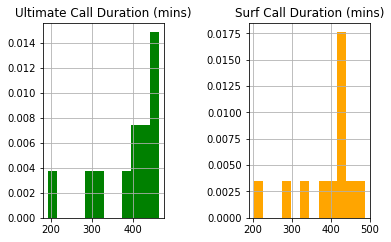

In [58]:
fig, axes = plt.subplots(1, 2)

def createhist(df1, df2, col, title1, title2, axes):
    df1[col].hist(ax=axes[0], bins=12, density=True, color = 'green')
    df2[col].hist(ax=axes[1], bins=12, density=True,color = "orange")
    axes[0].set_title(title1, fontsize=12)
    axes[1].set_title(title2, fontsize=12)
    fig.tight_layout(pad=3.0)

createhist(ultimate, surf, 'minute_mean', 'Ultimate Call Duration (mins)', 'Surf Call Duration (mins)', axes)    

### *Create 2 histograms not stratified by month in the same figure*

Separate 2 unstratified datasets for 2 plans: surf, ultimate

In [59]:
surf_gen = monthly_plan_clean.query('plan == "surf"', engine = 'python')
ultimate_gen = monthly_plan_clean.query('plan == "ultimate"', engine = 'python')

Create the function to plot the 2 histograms in the same figure, compare distribution by setting density = True in the hist() function

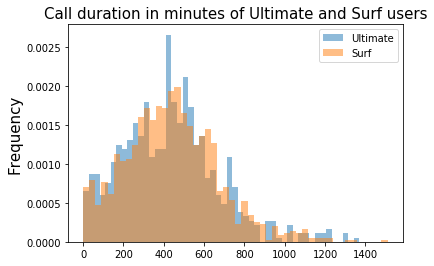

In [60]:
def createhist_nested(df1, df2, col, title, label1, label2):
    with np.errstate(invalid='ignore'): #add this command to ignore the NA values
        plt.hist(df1[col], alpha=0.5, density=True, label=label1, bins=50)
        plt.hist(df2[col], alpha=0.5, density=True, label=label2, bins=50)
        plt.legend(loc='upper right')
        plt.title(title, fontsize=15)
        plt.ylabel('Frequency', fontsize=15)  
        plt.show()
        
createhist_nested(ultimate_gen, surf_gen,'call_duration_minute', 
                  'Call duration in minutes of Ultimate and Surf users', 'Ultimate', 'Surf')

### *Create boxplot of monthly call duration for all users of the 2 plans*

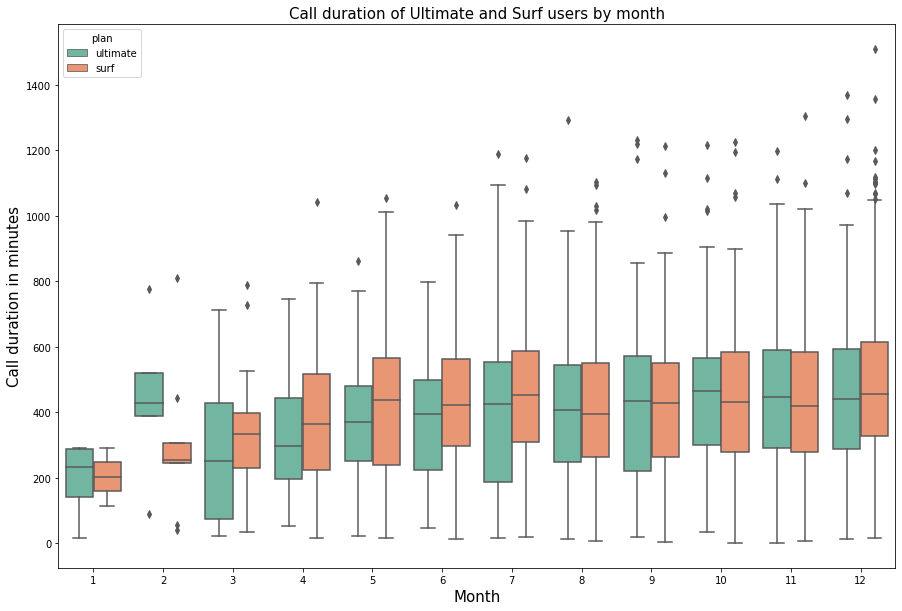

In [61]:
def createboxplot(x, y, hue, data, title, xlabel, ylabel):
    plt.figure(figsize=(15,10))
    sns.boxplot(x=x, y=y, hue="plan", data=data, palette="Set2")
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    
createboxplot('month', 'call_duration_minute', 'plan', 
              monthly_plan_clean, 'Call duration of Ultimate and Surf users by month', 
              'Month', 'Call duration in minutes')

### Describe the distribution of Call duration (in minutes)
- The mean phone call duration mostly lasts from 330 to 430 (around 6-8 months of the year), similar between Surf and Ultimate plan users.
- The data points are far from the mean among both plans users, i.e. there is a large dispersion in call duration.
- After 400 minutes, there are slightly more phone calls made by Surf plan users than that by Ultimate plan users
- People tend to make longer phone calls in the second half of the year. Ultimate users also have longer phone calls in Februrary

### Number of text messages 

### *Create  2 density histograms of monthly means side by side*

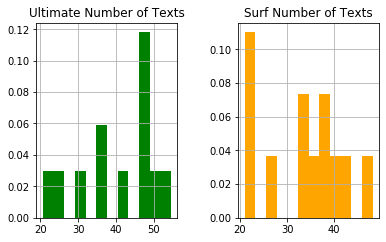

In [62]:
fig, axes = plt.subplots(1, 2)
createhist(ultimate, surf, 'mess_mean', 'Ultimate Number of Texts', 'Surf Number of Texts', axes)    

### *Create 2 histograms not stratified by month in the same figure*

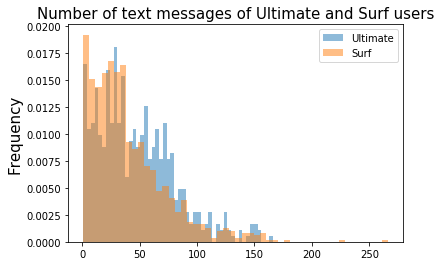

In [63]:
createhist_nested(ultimate_gen, surf_gen, 'message_sum', 
                  'Number of text messages of Ultimate and Surf users', 'Ultimate', 'Surf')

### *Create boxplot for all users of the 2 plans*

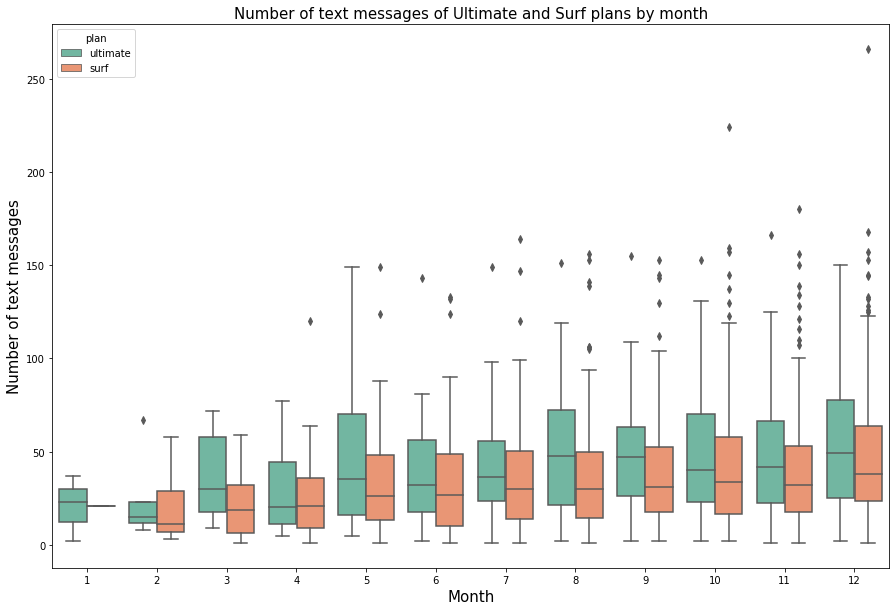

In [64]:
createboxplot('month', 'message_sum', 'plan', 
              monthly_plan_clean, 'Number of text messages of Ultimate and Surf plans by month', 
              'Month', 'Number of text messages')

### Describe the distribution of number of text messages
- There are two equal peaks in the Surf histogram, the first one revolves around 20-23 messages, the second one is around 33-41 messages. 
- The peak in the Ultimate histogram is around 47-50 messages.
- The data points are far from the mean among both plans users, i.e. there is a large dispersion in number of messages.
- The distribution is wider among Ultimate users than that of Surf users.
- People tended to text more as the year progressed. Ultimate users always text more than Surf users.

### Data volume

### *Create  2 density histograms of monthly means side by side*

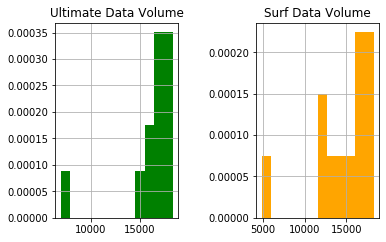

In [65]:
fig, axes = plt.subplots(1, 2)
createhist(ultimate, surf, 'data_mean', 'Ultimate Data Volume', 'Surf Data Volume', axes)    

### *Create 2 histograms not stratified by month in the same figure*

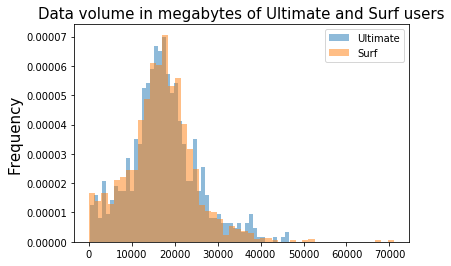

In [66]:
createhist_nested(ultimate_gen, surf_gen, 'data_volume', 
                  'Data volume in megabytes of Ultimate and Surf users', 'Ultimate', 'Surf')

### *Create boxplot for all users of the 2 plans*

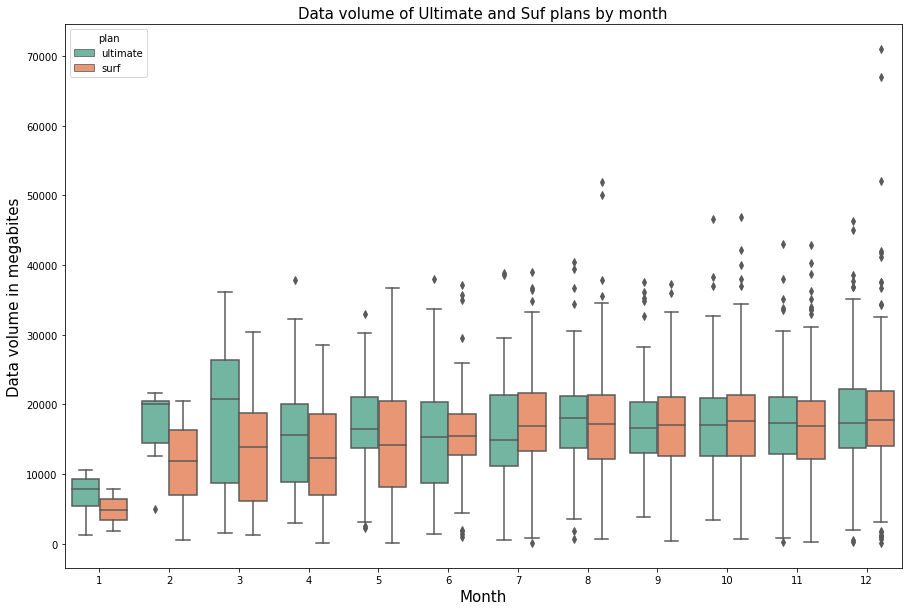

In [67]:
createboxplot('month', 'data_volume', 'plan', 
              monthly_plan_clean, 'Data volume of Ultimate and Suf plans by month', 
              'Month', 'Data volume in megabites')

### Describe the distribution of data volume
- The shape of the distributions of the two plans are quite similar: peak at around 17000mb, the spread looks similar too
- The distributions of both plans in terms of volume of data are narrower than that in terms of call duration and number of text messages. 
- In 11/12 months: the Surf users used greater than 10,000mb, Ultimate users even used more, i.e. greater than 14,000mb
- There is a sharp increase in data use from Jan to Feb among both Surf and Ultimate users. After this sharp increase, Ultimate users tend to use data more consistent throughout the year while there is a slightly increasing trend among Surf users as the year progressed.

# Step 4. Test the hypothesis
- The average profit from users of Ultimate and Surf calling plans differs.
- The average profit from users in NY-NJ area is different from that of the users from other regions.


In [68]:
monthly_plan_clean.info()
monthly_plan_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171 entries, 0 to 2170
Data columns (total 28 columns):
user_id                  2171 non-null int64
month                    2171 non-null int64
call_sum                 2136 non-null float64
call_duration_minute     2136 non-null float64
message_sum              1714 non-null float64
data_volume              2156 non-null float64
age                      2171 non-null int64
city                     2171 non-null object
reg_date                 2171 non-null datetime64[ns]
plan                     2171 non-null object
churn_date               2171 non-null datetime64[ns]
NY_NJ                    2171 non-null bool
churn_month              2171 non-null Int64
messages_included        2171 non-null int64
mb_per_month_included    2171 non-null int64
minutes_included         2171 non-null int64
usd_monthly_pay          2171 non-null int64
usd_per_gb               2171 non-null int64
usd_per_message          2171 non-null float64
usd_per_m

,user_id,month,call_sum,call_duration_minute,message_sum,data_volume,age,city,reg_date,plan,...,usd_per_message,usd_per_minute,minute_exceed,message_exceed,data_exceed,minute_exceed_usd,message_exceed_usd,data_exceed_usd,monthly_surcharge,monthly_profit
0,1000,12,16.0,124.0,11.0,1903.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,70.0
1,1001,8,27.0,182.0,30.0,6929.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,20.0
2,1001,9,49.0,315.0,44.0,13333.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,20.0
3,1001,10,65.0,393.0,53.0,22356.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,-6.83,0.0,0.0,68.3,68.3,88.3
4,1001,11,64.0,426.0,36.0,18524.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,...,0.03,0.03,0.0,0.0,-3.09,0.0,0.0,30.9,30.9,50.9


Prepare a new dataset called 'profit' from the 'monthly_plan_clean' data to test the hypotheses:
- Extract the necessary columns
- Calculate the cumulative profit for each user by adding the flat fee of the months that a user did not use a service (call, text, internet) as long as he/she is still in the plan

Calculate the total number of months that a user is still in the plan (from register month (reg_month) to churn month (churn_month))

Add "reg_month" for easier computation 

In [69]:
monthly_plan_clean['reg_month'] = monthly_plan_clean['reg_date'].dt.month

In [70]:
monthly_plan_clean['number_of_service_months'] = monthly_plan_clean['churn_month']-monthly_plan_clean['reg_month'] +1

In [71]:
profit = monthly_plan_clean[['user_id', 'plan', 'NY_NJ', 'monthly_surcharge', 
                             'reg_month','churn_month','number_of_service_months','usd_monthly_pay']]
len(profit['user_id'].unique()) #470
profit.head(20)

,user_id,plan,NY_NJ,monthly_surcharge,reg_month,churn_month,number_of_service_months,usd_monthly_pay
0,1000,ultimate,False,0.00,12,12,1,70
1,1001,surf,False,0.00,8,12,5,20
2,1001,surf,False,0.00,8,12,5,20
3,1001,surf,False,68.30,8,12,5,20
4,1001,surf,False,30.90,8,12,5,20
5,1001,surf,False,39.40,8,12,5,20
6,1002,surf,False,0.00,10,12,3,20
7,1002,surf,False,39.10,10,12,3,20
8,1002,surf,False,0.00,10,12,3,20
9,1003,surf,False,132.42,1,12,12,20


Group by user_id (calculate accumulative surcharge fee from monthly surcharge fee, so this fee does not including flat fee of the months that a user didn't use the service)

In [72]:
profit_grouped = profit.groupby(['user_id', 'plan', 'NY_NJ','reg_month','churn_month',
                                 'number_of_service_months','usd_monthly_pay'])[['monthly_surcharge']]\
                .agg(['sum']).reset_index()

profit_grouped.columns = ['user_id','plan','NY_NJ', 'reg_month','churn_month',
                          'number_of_service_months','usd_monthly_pay','accumulative_surcharge']

profit_grouped.head()

,user_id,plan,NY_NJ,reg_month,churn_month,number_of_service_months,usd_monthly_pay,accumulative_surcharge
0,1000,ultimate,False,12,12,1,70,0.00
1,1001,surf,False,8,12,5,20,138.60
2,1002,surf,False,10,12,3,20,39.10
3,1003,surf,False,1,12,12,20,132.42
4,1004,surf,False,5,12,8,20,422.60


Calculate total profit for each user: flat fee (value of each plan*number of months a user still in the service) + surcharge (as long as a user is still in the plan)

In [73]:
profit_grouped['total_profit'] = (profit_grouped['usd_monthly_pay']*profit_grouped['number_of_service_months'])\
                                    + profit_grouped['accumulative_surcharge']
profit_grouped.info()
profit_grouped.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 9 columns):
user_id                     470 non-null int64
plan                        470 non-null object
NY_NJ                       470 non-null bool
reg_month                   470 non-null int64
churn_month                 470 non-null int64
number_of_service_months    470 non-null int64
usd_monthly_pay             470 non-null int64
accumulative_surcharge      470 non-null float64
total_profit                470 non-null float64
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 30.0+ KB


,user_id,plan,NY_NJ,reg_month,churn_month,number_of_service_months,usd_monthly_pay,accumulative_surcharge,total_profit
0,1000,ultimate,False,12,12,1,70,0.00,70.00
1,1001,surf,False,8,12,5,20,138.60,238.60
2,1002,surf,False,10,12,3,20,39.10,99.10
3,1003,surf,False,1,12,12,20,132.42,372.42
4,1004,surf,False,5,12,8,20,422.60,582.60
5,1005,surf,False,11,12,2,20,17.60,57.60
6,1006,ultimate,False,11,12,2,70,9.73,149.73
7,1007,surf,False,7,12,6,20,664.91,784.91
8,1008,ultimate,False,8,12,5,70,0.00,350.00
9,1009,surf,False,4,12,9,20,688.72,868.72


Test normality of profit to choose an appropriate test
- Whole population
- Users from each of the two plans

The whole population

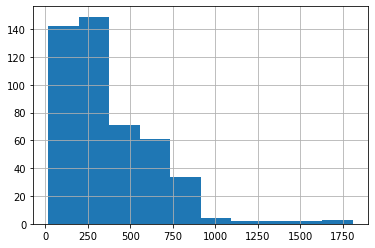

In [74]:
profit_grouped['total_profit'].hist()

Surf users

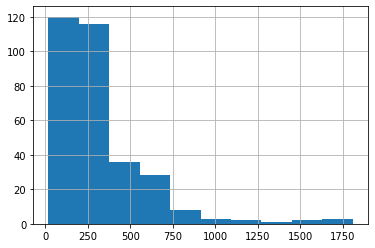

In [75]:
surf_profit = profit_grouped.query('plan == "surf"')

surf_profit['total_profit'].hist()

Ultimate users

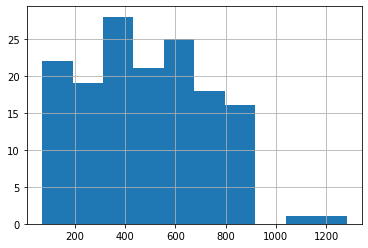

In [76]:
ultimate_profit = profit_grouped.query('plan == "ultimate"')

ultimate_profit['total_profit'].hist()

All of the distributions are not normal distributed, therefore we need to use a non-parametric test

### Research Question 1: Does the average profit from users of Ultimate and Surf calling plans differ?
- The data of profit from users of the 2 plans are not normal distributed --> therefore we need to apply a non-parametric test
- We want to compare the mean profit from the 2 groups of plan users: Ultimate users and Surf users
- Hypotheses:
    - H0: There is no difference in the average profit from users of Ultimate and Surf calling plans. 
    - H1: There is likely some difference in the average profit from users of Ultimate and Surf calling plans. 
- Appropriate test to use: Mann-Whitney U Test (equivalent of t-test)

In [77]:
#Run the test
stat, p = mannwhitneyu(ultimate_profit['total_profit'], surf_profit['total_profit'])

print('The average profit from Ultimate users:', '${:.2f}'.format(ultimate_profit['total_profit'].mean()))
print('The average profit from Surf users:', '${:.2f}'.format(surf_profit['total_profit'].mean()))

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('There is no difference in the average profit from users of Ultimate and Surf calling plans (fail to reject H0)')
else:
    print('There is likely some difference in the average profit from users of Ultimate and Surf calling plans (reject H0)')


The average profit from Ultimate users: $477.88
The average profit from Surf users: $311.94
Statistics=13647.000, p=0.000
There is likely some difference in the average profit from users of Ultimate and Surf calling plans (reject H0)


### Research Question 2: Does the average profit from users in NY-NJ area is different from that of the users from other regions?
- The data of profit from users from NY-NJ and other region are not normal distributed --> therefore we need to apply a non-parametric test
- We want to compare the mean profit from the 2 groups of users: NY-NJ users and other region users
- Hypotheses:
    - H0: There is no difference in the average profit from users in NY-NJ area and users in other regions. 
    - H1: There is likely some difference in the average profit from from users in NY-NJ area and users in other regions. 
- Appropriate test to use: Mann-Whitney U Test (equivalent of t-test)

Test the normality of the distribution of profit from NY-NJ users

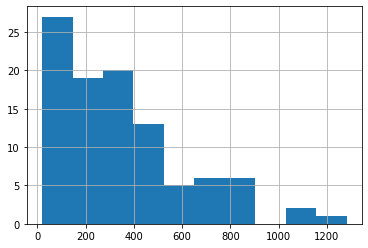

In [78]:
nynj_profit = profit_grouped.query('NY_NJ == True')

nynj_profit['total_profit'].hist()

Test the normality of the distribution of profit from other region users

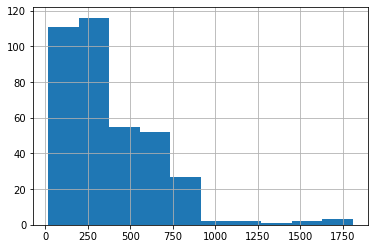

In [79]:
other_profit = profit_grouped.query('NY_NJ == False')

other_profit['total_profit'].hist()

All distributions are not normal distributed, therefore we need to use a non-parametric test too

In [80]:
#Run the test
stat, p = mannwhitneyu(nynj_profit['total_profit'], other_profit['total_profit'])

print('The average profit from NY-NJ users:', '${:.2f}'.format(nynj_profit['total_profit'].mean()))
print('The average profit from other region users:', '${:.2f}'.format(other_profit['total_profit'].mean()))

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('There is no difference in the average profit from users in NY-NJ area and users in other regions (fail to reject H0)')
else:
    print('There is likely some difference in the average profit from users in NY-NJ area and users in other regions (reject H0)')


The average profit from NY-NJ users: $349.14
The average profit from other region users: $369.55
Statistics=17668.500, p=0.281
There is no difference in the average profit from users in NY-NJ area and users in other regions (fail to reject H0)


### Conclusion for Step 4:
- Appropriate test to use for both research questions is the Mann-Whitney U Test because the distribution of the profit data is not normal
- Conclusion for the research question 1: ***There is likely some difference in the average profit from users of Ultimate and Surf calling plans (reject H0)***
- Conclusion for the research question 2: ***There is no difference in the average profit from users in NY-NJ area and users in other regions (fail to reject H0)***

# General Conclusion
## - Step 1: Open the data file and study the general information
    - There are 5 separate dataframes which were merged in the next steps. The common variable that will be used to merge is user_id (int) and plan_name (object)
## - Step 2: Prepare the data
    - Convert the data to the necessary types (float, int, datetime)
    - Find and eliminate errors in data: identify if there is any duplicates (no), identify and remove outliers in each dataset, leave the 0-minute-calls as they are because they are highly likely missed calls
    - For each user, find the monthly number of calls made, call duration in minutes, number of text message, data volume and profit (flat fee + exceeding fee)
## - Step 3: Analyze the data
    - Find the minutes, texts, and volume of data the users of each plan require per month. 
    - Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions
## - Step 4: Test the hypotheses
    - Conclusion for the research question 1: There is likely some difference in the average profit from users of Ultimate and Surf calling plans (reject H0)
    - Conclusion for the research question 2: There is no difference in the average profit from users in NY-NJ area and users in other regions (fail to reject H0)

---- End of the Project ----